# Analysis of Results
In this notebook, we go through how to quickly analyse the reults of a trained RIM.

In this example, we trained a RIM to deconvolve X-ray spectra. Therefore, we have the instrumental response matrices (A), the observed spectra (y), and the true spectra (x).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pickle
from scipy.stats import chisquare
#plt.style.use("/home/carterrhea/Documents/dark.mplstyle")
plt.style.use('fivethirtyeight')


In [3]:
# Path to rmfs (A)
responses_data = pickle.load(open('/home/carterrhea/Documents/RIM_data/rmfs_new.pkl', 'rb'))
# Path to observed spectra (y)
spectra_data = pickle.load(open('/home/carterrhea/Documents/RIM_data/spectra_new.pkl', 'rb'))
# Path to true spectra (x)
true_spectra_data = pickle.load(open('/home/carterrhea/Documents/RIM_data/true_new.pkl', 'rb'))
# Trained RIM solutions
ysol  = pickle.load(open('/home/carterrhea/Documents/RIM_data/ysol_test_1500n_30e_4ts_32b_2.00E-03lr_new.pkl', 'rb'))
# These values are defined for this specific problem
min_ = 35
max_ = 175
# Read in A, x, and y
spectra_x = [data[1][0][0][min_:max_] for data in spectra_data.items()]
spectra_y = [data[1][0][1][min_:max_] for data in spectra_data.items()]
true_spectra_y = [data[1] for data in true_spectra_data.items()]
spectra_response = [data[1][1] for data in spectra_data.items()]
responses = [responses_data[val][min_:max_,min_:max_] for val in spectra_response]
noise = [data[1][0][2][min_:max_] for ct,data in enumerate(spectra_data.items())]

# Create training and validation sets
valid_percentage = 0.9
test_percentage = 1.0
len_X = len(true_spectra_y)
X_test = true_spectra_y[int(valid_percentage*len_X):int(test_percentage*len_X)]
Y_test = spectra_y[int(valid_percentage*len_X):int(test_percentage*len_X)]
A_test = responses[int(valid_percentage*len_X):int(test_percentage*len_X)]
C_test = noise[int(valid_percentage*len_X):]


2023-07-18 19:32:45.232912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 19:32:51.052484: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 19:32:51.056527: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
# Unravel batched solutions into (Spectra, Time step, Solution)
deconvolved = np.array(ysol[0]).transpose(1,0,2)
for batch in ysol[1:]:
    single_batch = np.array(batch).transpose(1,0,2)
    deconvolved = np.concatenate((deconvolved, single_batch), axis=0)
    

Now we can query a single solution over all time steps with deconvolved[i]

And we can query a single time step of this solution with deconvolved[i][t]

## Solution Plots


### Single solution over each time step
Here we query the first solution

Text(0.5, 0, 'Energy (keV)')

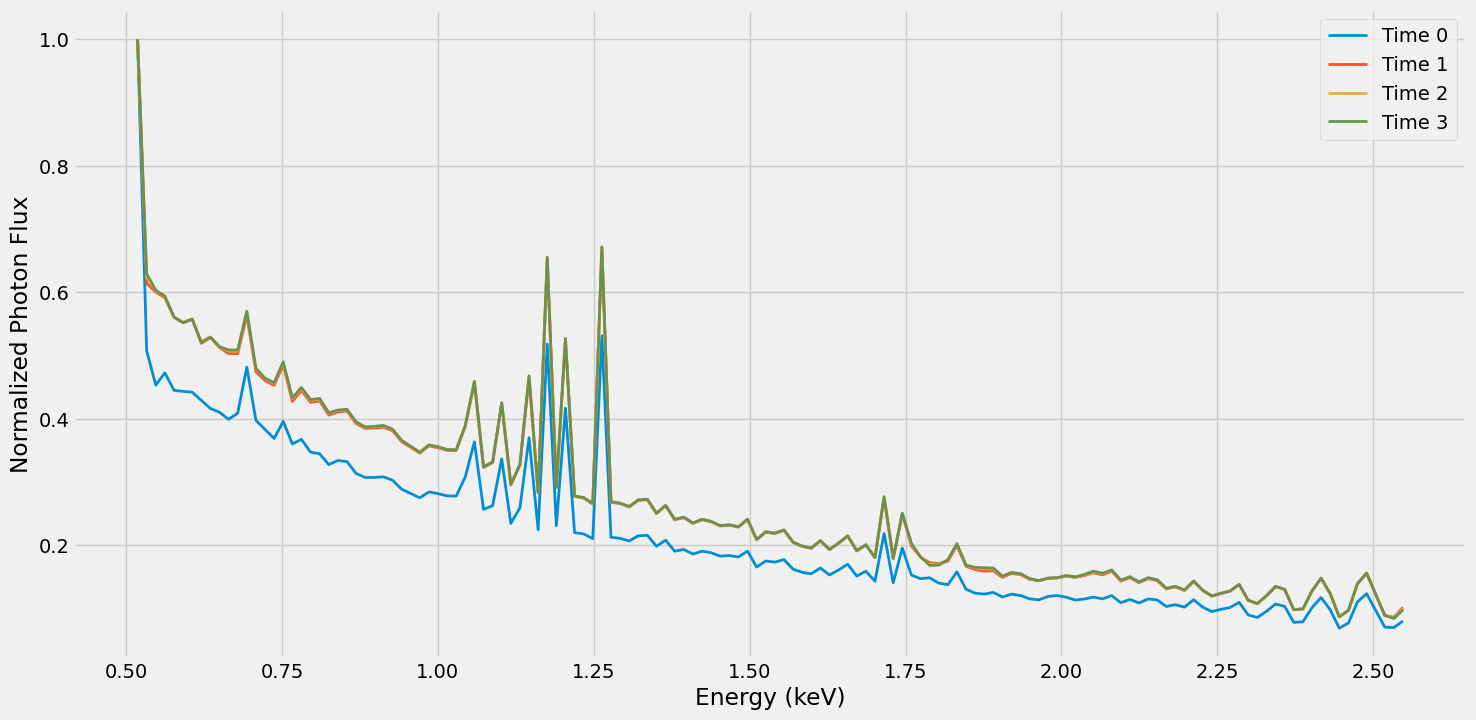

In [5]:
fig = plt.figure(figsize=(16,8))
for i in range(4):
    ysol_plot = deconvolved[-1][i]
    plt.plot(spectra_x[-1], ysol_plot/np.max(ysol_plot), label='Time %i'%(i), linewidth=2)
plt.legend()
#plt.yscale('log')
#plt.xscale('log')
plt.ylabel('Normalized Photon Flux')
plt.xlabel('Energy (keV)')

## Solution at last time step with observed and true spectra

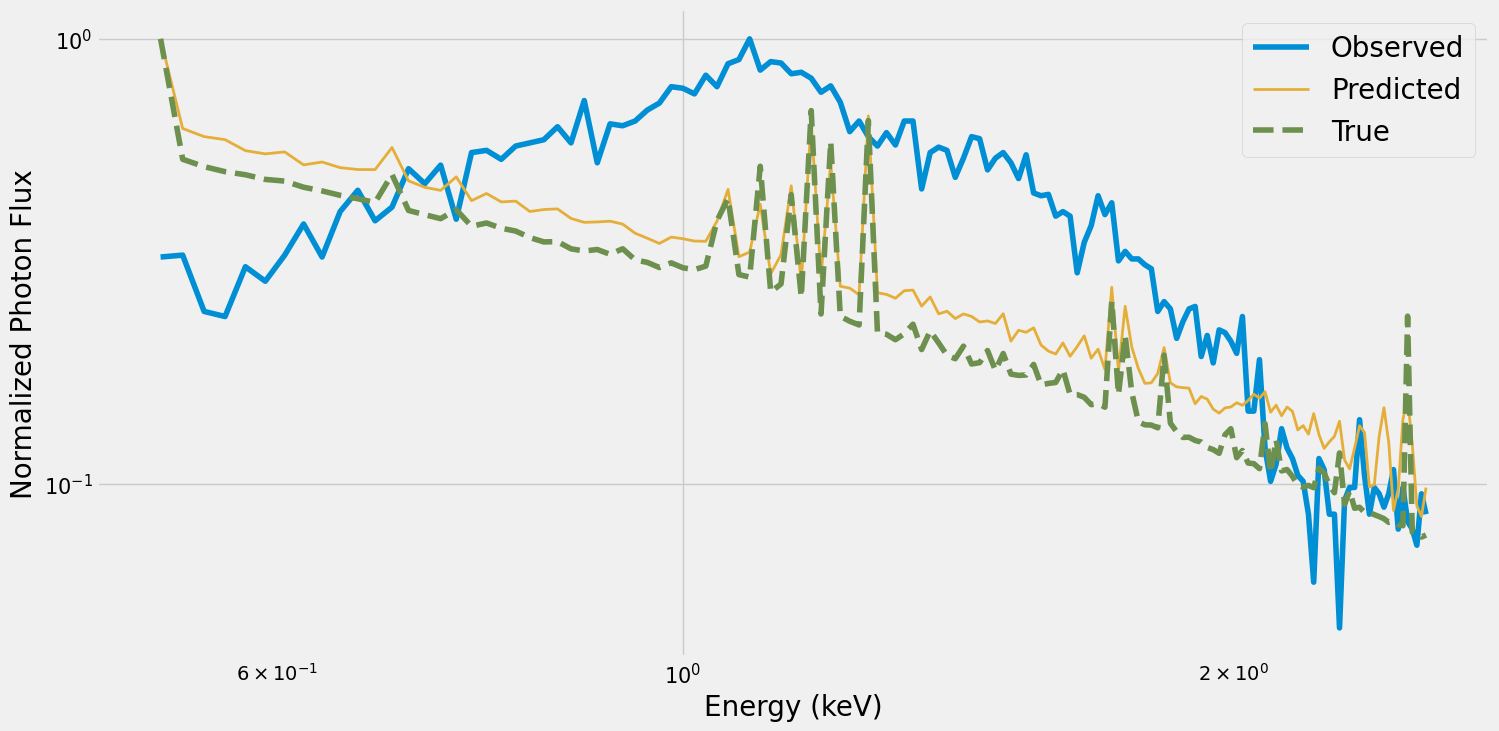

In [6]:
fig = plt.figure(figsize=(16,8))
test_index = -1
ysol_plot = deconvolved[-1][test_index]  # Last solution at last time step
plt.plot(spectra_x[-1], Y_test[test_index]/np.max(Y_test[test_index]), label='Observed')
plt.plot(spectra_x[-1], ysol_plot/np.max(ysol_plot), label='Predicted', linewidth=2, color='C2')
plt.plot(spectra_x[-1], X_test[test_index][-1][min_:max_]/np.max(X_test[test_index][-1][min_:max_]), label='True', linestyle='--', color='C3')
plt.legend(prop={'size': 20})
plt.ylabel('Normalized Photon Flux', fontsize=20)
plt.xlabel('Energy (keV)', fontsize=20)
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig('../../RIM_Plots/RIM_results.png', facecolor='None', edgecolor='none')

In [7]:
int((test_percentage-valid_percentage)*len_X)

999

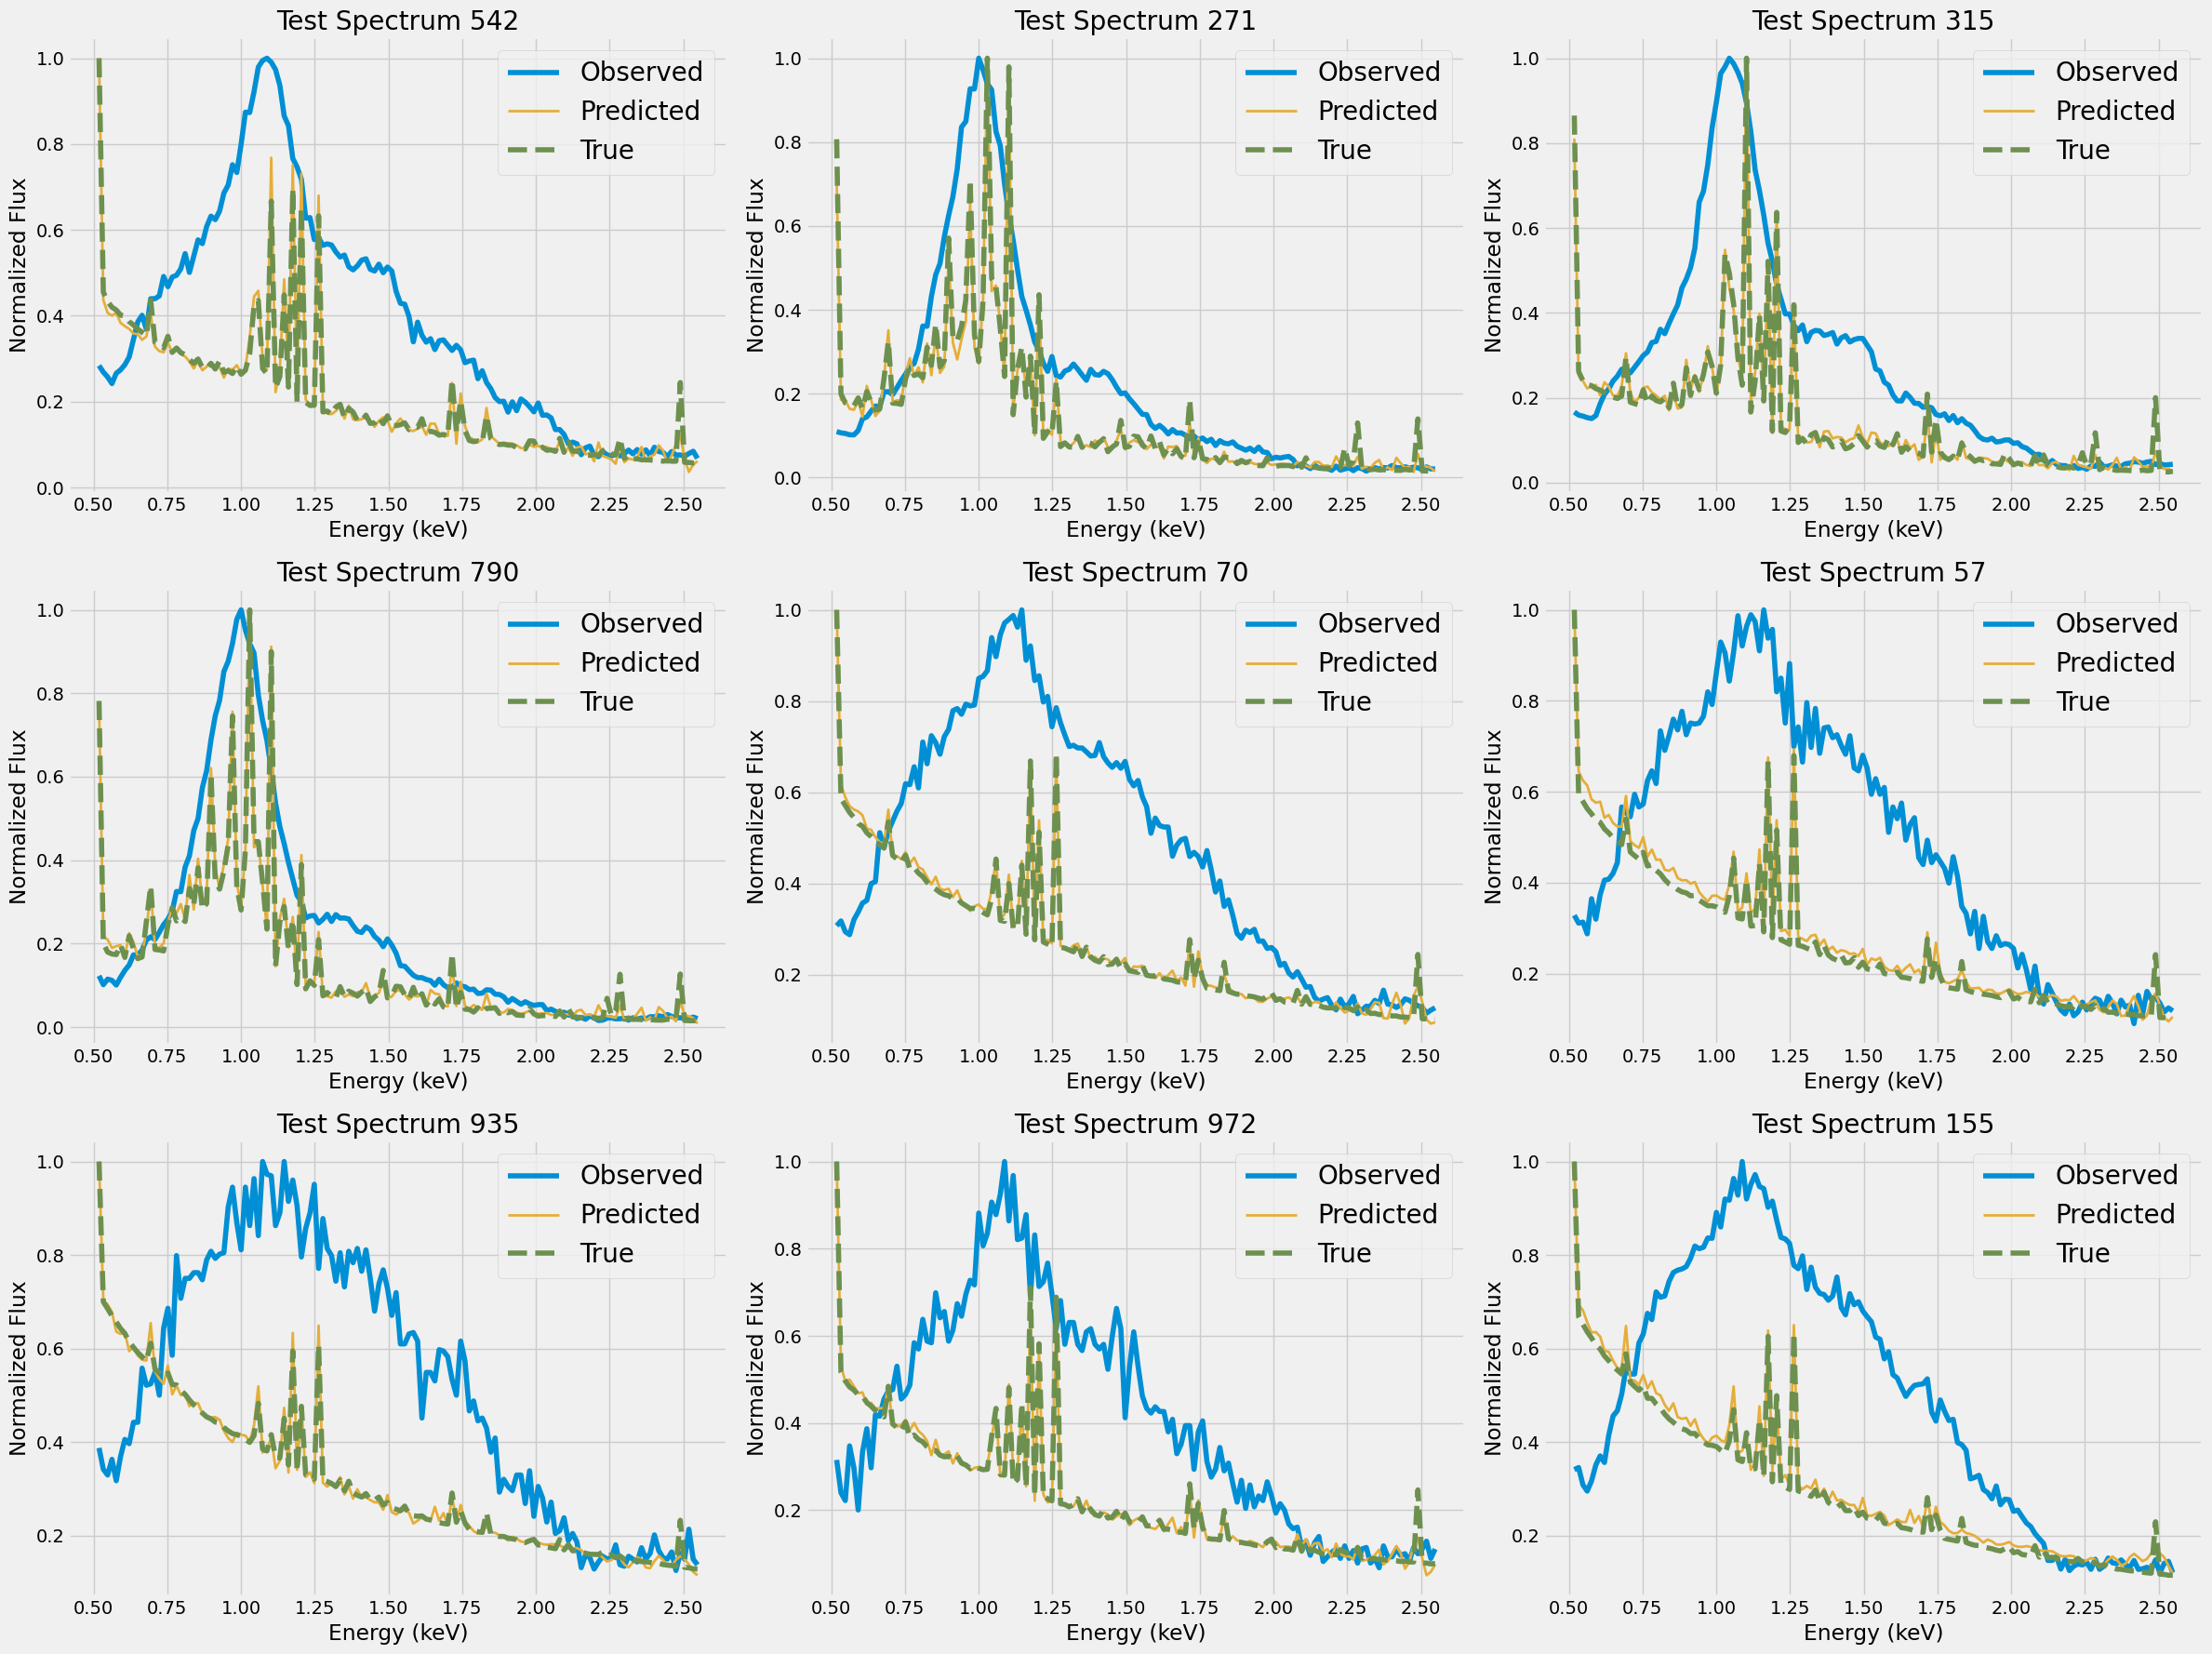

In [8]:
nrows = 3
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(24,18))
plt.ylabel('Normalized Photon Flux')
plt.xlabel('Energy (keV)')
for i in range(nrows):
    for j in range(ncols):
        test_index = int(np.random.uniform(0, int((test_percentage-valid_percentage)*len_X)-10))
        ysol_plot = deconvolved[test_index][-1]  # Last solution at last time step
        axs[i,j].plot(spectra_x[-1], Y_test[test_index]/np.max(Y_test[test_index]), label='Observed')
        axs[i,j].plot(spectra_x[-1], ysol_plot/np.max(ysol_plot), label='Predicted', linewidth=2, color='C2')
        axs[i,j].plot(spectra_x[-1], X_test[test_index][-1][min_:max_]/np.max(X_test[test_index][-1][min_:max_]), label='True', linestyle='--', color='C3')
        axs[i,j].legend(loc=1, prop={'size': 20})
        axs[i,j].title.set_text('Test Spectrum %i'%test_index)
        axs[i,j].set_facecolor('None')
        axs[i,j].set_ylabel('Normalized Flux')
        axs[i,j].set_xlabel('Energy (keV)')

plt.tight_layout()

plt.savefig('../../RIM_Plots/RIM_results_random_sample.png', facecolor='None', edgecolor='none')


In [ ]:
chisq=np.sum((X_test[1][-1][min_:max_]- deconvolved[1][-1])**2)
print('The chi-squared value is %.2f'%chisq)

In [ ]:
print(len(deconvolved[0]))

In [ ]:
fig = plt.figure(figsize=(16,8))
test_index = -10
ysol_plot = deconvolved[test_index][-1]  # Last solution at last time step
plt.plot(spectra_x[-1], Y_test[test_index]/np.max(Y_test[test_index]), label='Observed')
plt.plot(spectra_x[-1], X_test[test_index][-1][min_:max_]/np.max(X_test[test_index][-1][min_:max_]), label='True', linewidth=2, color='C2')
for i in range(4):
    plt.plot(spectra_x[-1], deconvolved[test_index][i]/np.max(deconvolved[test_index][i]), label='Predicted Time %i'%i, linestyle='--')
plt.legend(prop={'size': 20})
plt.ylabel('Normalized Photon Flux', fontsize=20)
plt.xlabel('Energy (keV)', fontsize=20)
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig('../../RIM_Plots/RIM_results_times.png', facecolor='None', edgecolor='none')

### Verification
Let's verify that each spectrum at a fixed time step isnt the same

In [ ]:
plt.style.use("/home/carterrhea/Documents/dark.mplstyle")

fig = plt.figure(figsize=(16,8))
for i in range(10):
    ysol_plot = deconvolved[i][-1]
    plt.plot(spectra_x[-1], ysol_plot/np.max(ysol_plot), label='Deconvolved %i'%i, linewidth=1)
#plt.legend()